In [1]:
!pip install "ultralytics<=8.3.40"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import torch
from transformers import Idefics3ForConditionalGeneration, AutoProcessor
from PIL import Image, ImageDraw, ImageFont

model_id = "HuggingFaceTB/SmolVLM-Instruct"

In [6]:
system_message = """
You are a Vision-Language Model specialized in understanding real-world object images with annotated bounding boxes.
Your task is to analyze the visual content, including detected objects, their locations, and appearances, and respond accurately to natural language queries.

Possible queries include:
- Describing the objects in the image in detail
- Estimating market prices based on visual and contextual cues
- Answering specific factual or contextual questions about the image

Your responses should be concise, accurate, and directly based on the visual information. Use the image content, object positions, and any visual clues to inform your answers. Avoid unnecessary explanation unless explicitly requested.
"""

In [ ]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    
    text_input = processor.apply_chat_template(
        sample[1:2], add_generation_prompt=True 
    )

    image_inputs = []
    image = sample[1]["content"][0]["image"]
    if image.mode != "RGB":
        image = image.convert("RGB")
    image_inputs.append([image])

   
    model_inputs = processor(
        # text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    ) 

 
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)


    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

 
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0] 

In [8]:
def predict(msg, img_path):
    model = Idefics3ForConditionalGeneration.from_pretrained(
      model_id,
      device_map="auto",
      torch_dtype=torch.bfloat16,
      _attn_implementation="eager",
    )

    processor = AutoProcessor.from_pretrained(model_id)

    adapter_path = "/content/drive/MyDrive/nlp_project_elte/smolvlm-instruct-trl-sft-ChartQA"
    model.load_adapter(adapter_path)
    yolo = YOLO("/content/drive/MyDrive/nlp_project_elte/od/od/saved_model.pt")
    pred = yolo(img_path)
    RESIZE_SIZE = (512,512)
    image = Image.open(img_path).convert("RGB")

    # Resize + BBox Adjust
    original_size = image.size
    image = image.resize(RESIZE_SIZE)

    scale_x = RESIZE_SIZE[0] / original_size[0]
    scale_y = RESIZE_SIZE[1] / original_size[1]

    draw = ImageDraw.Draw(image)
    bboxes = pred[0].boxes.xyxy.tolist()
    for box in bboxes:
        scaled_box = [
            int(box[0] * scale_x),
            int(box[1] * scale_y),
            int(box[2] * scale_x),
            int(box[3] * scale_y)
        ]
    draw.rectangle(scaled_box, outline="red", width=5)

    input = [{'role': 'system',
      'content': [{'type': 'text',
        'text': system_message}]},
    {'role': 'user',
      'content': [{'type': 'image',
        'image': image},
      {'type': 'text',
        'text': msg}]},
    {'role': 'assistant',
      'content': [{'type': 'text',
        'text': ""}]}]

    return generate_text_from_sample(model, processor, input), image

In [9]:
img_path = "/content/drive/MyDrive/nlp_project_elte/data/159347/20250320_120454_anonimized.jpg"
out, img = predict("Describe object that is in the rectangle",img_path )

config.json:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]


image 1/1 /content/drive/MyDrive/nlp_project_elte/data/159347/20250320_120454_anonimized.jpg: 480x640 1 Automobile, 55.7ms
Speed: 18.8ms preprocess, 55.7ms inference, 402.4ms postprocess per image at shape (1, 3, 480, 640)


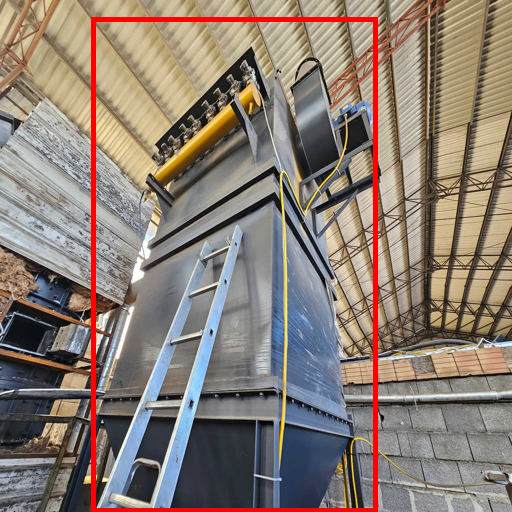

In [ ]:
img

In [ ]:
out

' The image shows a large industrial machine, likely a dust collector, with a ladder attached to it. The machine is made of metal and has a cylindrical body with a conical top. It is painted in a dark color, possibly black or dark gray, and has a yellow fan attached to the top. The machine is placed in a warehouse-like setting with a metal roof and brick walls. There is a ladder attached to the side of the machine, which is painted in a light color, possibly blue or gray. The machine appears to be in good condition, with no visible damage or rust.'


image 1/1 /content/drive/MyDrive/nlp_project_elte/data/159347/20250320_120915_anonimized.jpg: 480x640 1 Automobile, 8.6ms
Speed: 4.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
 The image shows a metal plate with specifications and technical details of a machine, likely a vibration feeder, manufactured by Henan Recycling Technology Co., Ltd. The plate is likely part of the machine's documentation or maintenance documentation. 

The text on the plate includes:
- Model: FYZW-960
- Voltage/Frequency: 380V, 50Hz
- Transmission Power: 0.600-0.60 kW
- Hopper Width: 360 mm
- Hopper Length: 1630 mm
- Date of Manufacture: 2024-08-15
- Company Address: Jiaozuo Henan
- Service Telephone: +86-391-6196111

The plate is made of metal and has a brushed finish, typical of industrial equipment documentation.


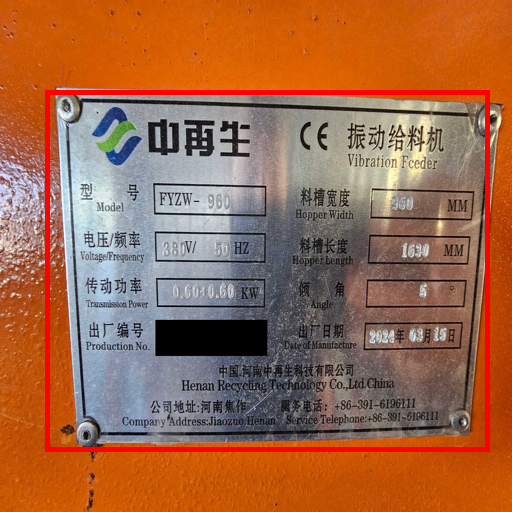

In [ ]:
img_path = "/content/drive/MyDrive/nlp_project_elte/data/159347/20250320_120915_anonimized.jpg"
out, img = predict("Describe object that is in the rectangle",img_path )
print(out)
img


image 1/1 /content/drive/MyDrive/nlp_project_elte/data/157515_v2/IMG_20240402_134851_anonimized.jpg: 480x640 1 Automobile, 16.2ms
Speed: 5.3ms preprocess, 16.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)
 10000.


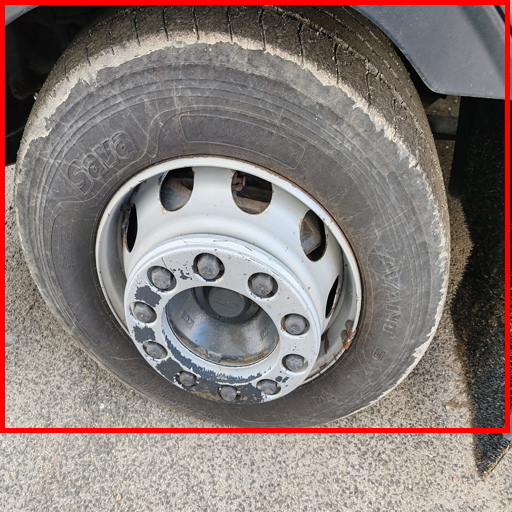

In [ ]:
img_path = "/content/drive/MyDrive/nlp_project_elte/data/157515_v2/IMG_20240402_134851_anonimized.jpg"
out, img = predict("What is price of the object detected?",img_path )
print(out)
img


image 1/1 /content/drive/MyDrive/nlp_project_elte/data/165720/IMG_20241118_100958_anonimized.jpg: 480x640 1 Automobile, 10.7ms
Speed: 4.8ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
 25,000.0.


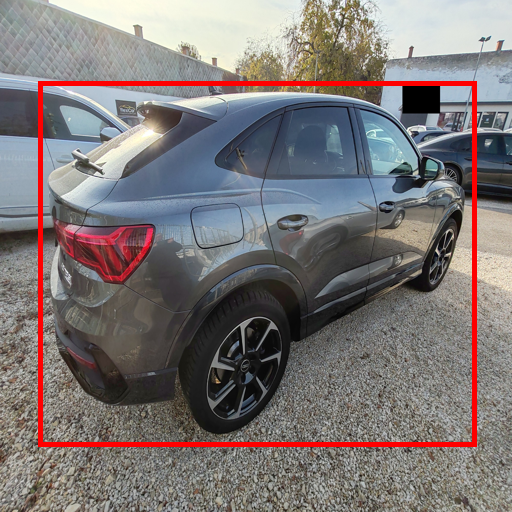

In [11]:
img_path = "/content/drive/MyDrive/nlp_project_elte/data/165720/IMG_20241118_100958_anonimized.jpg"
out, img = predict("What is price of the object detected?",img_path )
print(out)
img